# Dataset Creation Scripts

Here we will elaborate a random line samples generator for our hough line peak extraction model. We need to first generate random lines, followed by random noise and then apply hough transform to get our desired prediction label.

## Imports

In [37]:
import random
import math
import numpy as np
from skimage import draw
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.transform import hough_line, hough_line_peaks
import cv2 as cv

# notebooks only
%matplotlib inline
random.seed(420)  # comment here for 'truly' random


## Aux Functions

In [38]:
def random_coords(width, height):
    return int(random.random() * width), int(random.random() * height)


In [39]:
def draw_random_lines(numLines, image, dims):
    for _ in range(numLines):
        x0, y0 = random_coords(dims[0], dims[1])
        x1, y1 = random_coords(dims[0], dims[1])
        image[draw.line(x0, y0, x1, y1)] = 255

    return image


In [40]:
def draw_bezier_noise(numNoise, image, dims):
    for _ in range(numNoise):
        r0, c0 = random_coords(dims[0], dims[1])
        r1, c1 = random_coords(dims[0], dims[1])
        r2, c2 = random_coords(dims[0], dims[1])
        image[draw.bezier_curve(r0, c0, r1, c1, r2, c2, 0.5)] = 255
    return image


In [41]:
def generate_image(numLines=1, numNoise=1, dims=(200, 200)):
    blank = np.zeros(dims)
    img = draw_random_lines(numLines, blank, dims)
    img = draw_bezier_noise(numNoise, img, dims)
    return img.astype('uint8')


In [42]:
# def get_hough_transform(image):
#     tested_angles = np.linspace(0, np.pi, 360, endpoint=False)
#     # tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
#     hspace, angles, dists = hough_line(image, theta=tested_angles)
#     coords = []
#     for _, theta, rho in zip(*hough_line_peaks(hspace, angles, dists)):
#         coords.append((rho, theta))

#     ht = np.log(1 + hspace)
#     return ht, coords


In [43]:
def get_hough_transform(image):
    tested_angles = np.linspace(0, np.pi, 360, endpoint=False)
    # tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    hspace, angles, dists = hough_line(image, theta=tested_angles)
    _, theta, rho =hough_line_peaks(hspace, angles, dists)
    coords = []
    for rho, theta in zip(rho, theta):
        coords.append((rho, theta))
    ht = np.log(1 + hspace)
    return ht, coords


In [44]:
def get_pixel_coords(lines):
    coords = []
    for rho, theta in lines:
        t = theta * 360 / np.pi
        r = rho + 283
        coords.append((r, t))
    return coords


In [45]:
def draw_detected_lines(image, coords):
    result = np.zeros(image.shape)
    # calculate the x,y coordinates of the line and draw it on the image
    for rho, theta in coords:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        x1 = int(x0 + 1000 * (-np.sin(theta)))
        y1 = int(y0 + 1000 * (np.cos(theta)))
        x2 = int(x0 - 1000 * (-np.sin(theta)))
        y2 = int(y0 - 1000 * (np.cos(theta)))
        cv.line(result, (x1, y1), (x2, y2), (255, 0, 0), 1)
    plt.imshow(result, cmap=cm.gray)
    plt.show()


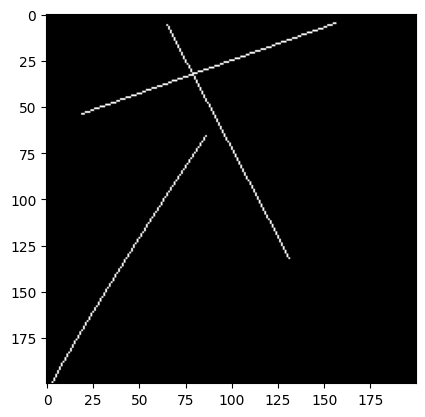

In [46]:
img = generate_image(numLines=2)
plt.imshow(img, cmap=cm.gray)

In [47]:
ht, lines = get_hough_transform(img)

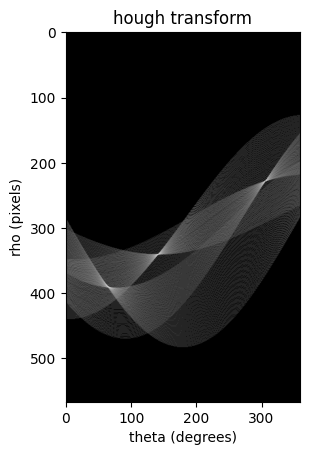

In [48]:
fig, ax = plt.subplots()
ax.set_title('hough transform')
ax.set_xlabel('theta (degrees)')
ax.set_ylabel('rho (pixels)')
ax.imshow(ht, cmap=cm.gray)
plt.show()

In [49]:
pixel_coords = get_pixel_coords(lines)
print(pixel_coords)

[(340.0, 141.0), (228.0, 305.0), (390.0, 64.0)]


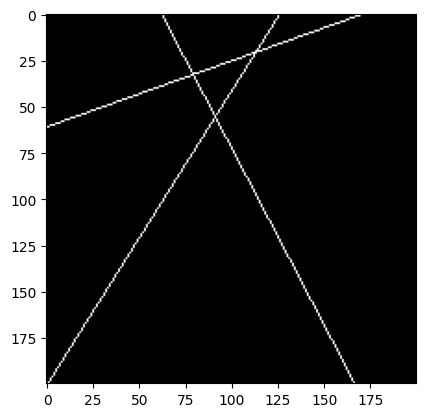

In [50]:
draw_detected_lines(img, lines)